In [1]:
from pathlib import Path 
import sys 
import warnings
sys.path.append(str(Path.cwd().parent))

In [5]:
# versioning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
from utils import predictors, data_loading as dl
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sunspots = dl.DataLoader(dl.DATASET.SUNSPOTS)
electricity = dl.DataLoader(dl.DATASET.ELECTRICITY)
mackey_glass = dl.DataLoader(dl.DATASET.MACKEY_GLASS)
temperature = dl.DataLoader(dl.DATASET.TEMPERATURE)

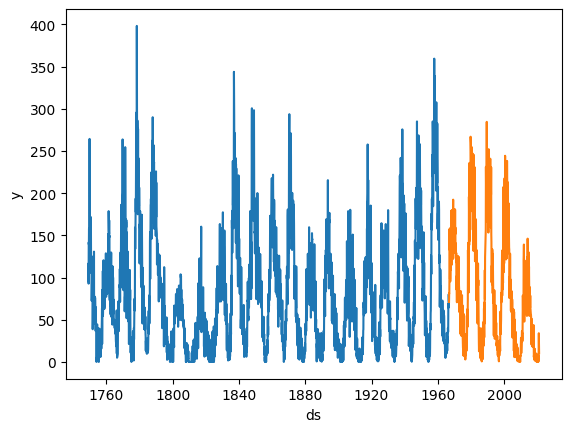

In [5]:
sns.lineplot(data=sunspots.train_df, x="ds", y="y")
sns.lineplot(data=sunspots.val_df, x="ds", y="y")
plt.show()

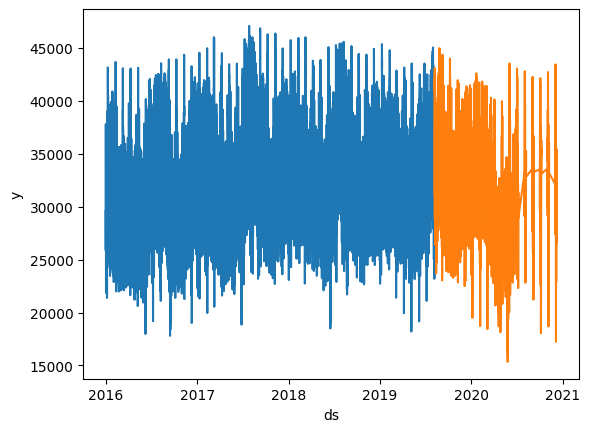

In [6]:
sns.lineplot(data=electricity.train_df, x="ds", y="y")
sns.lineplot(data=electricity.val_df, x="ds", y="y")
plt.show()

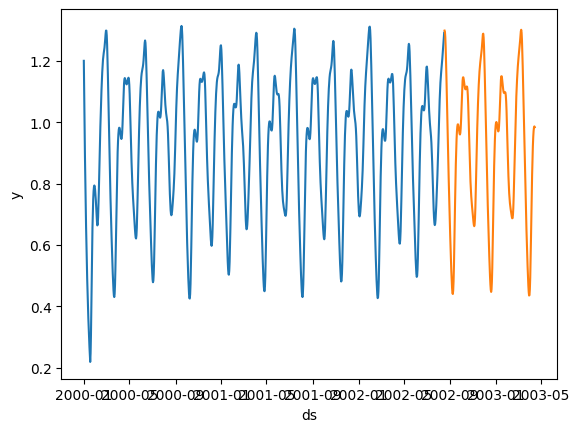

In [6]:
sns.lineplot(data=mackey_glass.train_df, x="ds", y="y")
sns.lineplot(data=mackey_glass.val_df, x="ds", y="y")
plt.show()

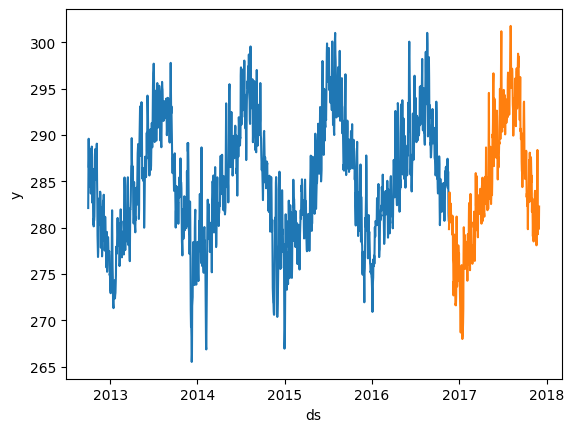

In [7]:
sns.lineplot(data=temperature.train_df, x="ds", y="y")
sns.lineplot(data=temperature.val_df, x="ds", y="y")
plt.show()

# Forecasting with XGBoost

## Train model

In [160]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
xgboost_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 300,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        }
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        }
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 month lag": "30 days",
            "15 days lag": "15 days"
        } 
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = xgboost_params[dataset.name]
    model = predictors.XGBoostPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)
DATASET.ELECTRICITY
(31564, 2)
DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


## Evaluate model

(653,) (653, 1)


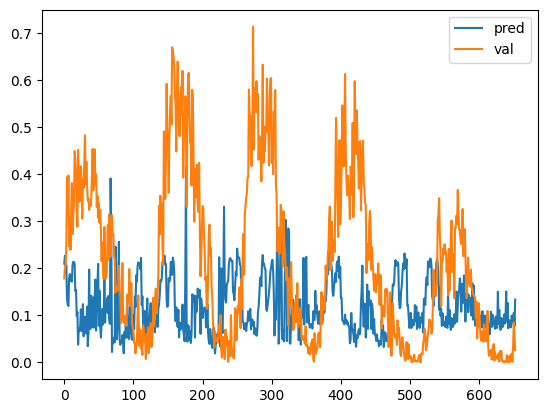

(7891,) (7891, 1)


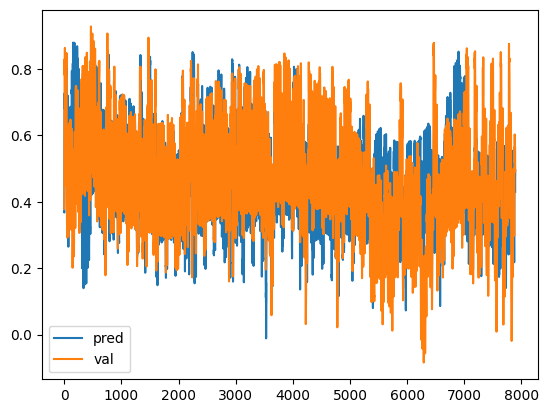

(378,) (378, 1)


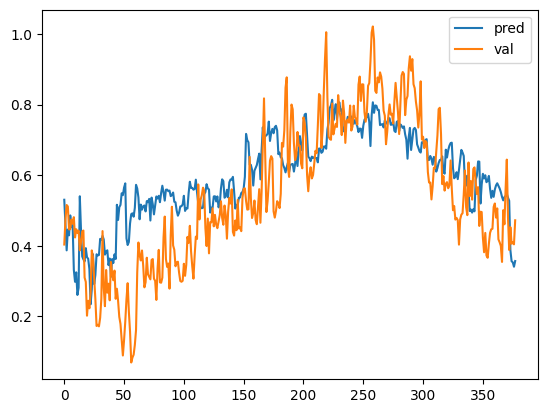

In [159]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)
    print(y_pred.shape, df_val.shape)
    plt.plot(y_pred, label="pred")
    plt.plot(y_val, label="val")
    plt.legend()
    plt.show()

# Forecasting with LightGBM

## Train model

In [156]:
models = {}
datasets = [sunspots, electricity, mackey_glass, temperature]
lightgbm_params = {
    dl.DATASET.SUNSPOTS: {
        "n_estimators": 1000,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "50 years lag": "18262 days",
            "40 years lag": "14610 days",
            "30 years lag": "10958 days"
        }
    },
    dl.DATASET.ELECTRICITY: {
        "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": True,
        "lags": {
            "8 months lag": "242 days",
            "6 months lag": "182 days",
            "4 months lag": "91 days"
        }
    },
    dl.DATASET.MACKEY_GLASS: {
        "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
    },
    dl.DATASET.TEMPERATURE: {
       "n_estimators": 1000,
        "max_depth": 5,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "4 months lag": "91 days",
            "1 months lag": "30 days",
            "15 days lag": "15 days"
        } 
    }
}

for dataset in datasets:
    print(dataset.name)
    df_train = dataset.y_train_df
    print(df_train.shape)
    params = lightgbm_params[dataset.name]
    model = predictors.LightGBMPredictor(**params)
    model.fit(df_train)
    models[dataset.name] = model    

DATASET.SUNSPOTS
(2612, 2)
DATASET.ELECTRICITY
(31564, 2)
DATASET.MACKEY_GLASS
(960, 2)
DATASET.TEMPERATURE
(1509, 2)


## Evaluate model

(653,) (653, 1)


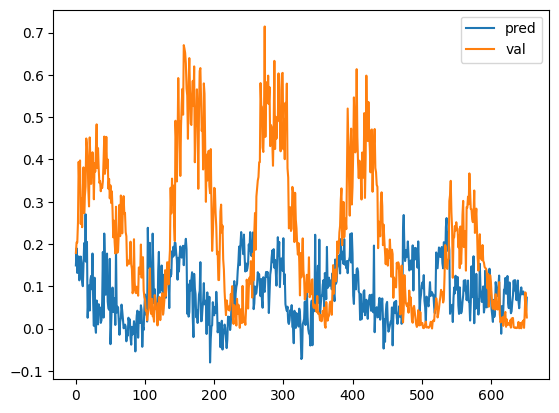

(7891,) (7891, 1)


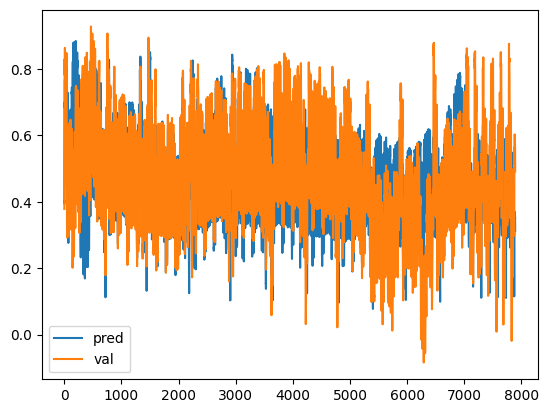

(241,) (241, 1)


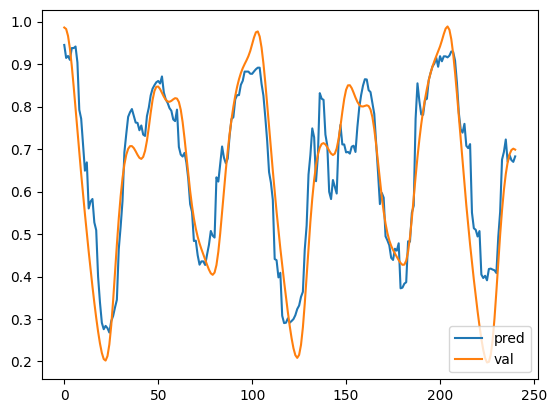

(378,) (378, 1)


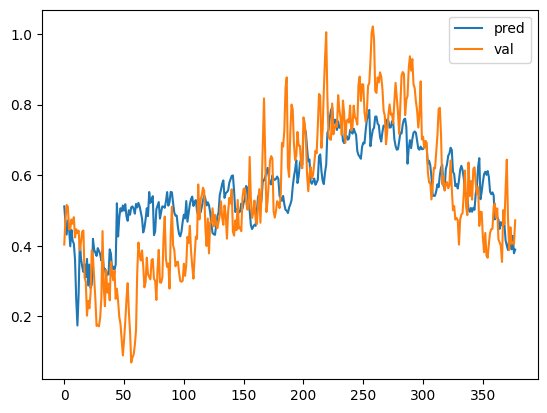

In [157]:
forecasts = {}
for i, dataset in enumerate(datasets):
    y_val = dataset.y_val
    df_val = pd.DataFrame({"ds": dataset.y_val_df.ds})
    model = models[dataset.name]
    y_pred = model.forecast(df_val)
    print(y_pred.shape, df_val.shape)
    plt.plot(y_pred, label="pred")
    plt.plot(y_val, label="val")
    plt.legend()
    plt.show()

0      1749-01-31
1      1749-02-28
2      1749-03-31
3      1749-04-30
4      1749-05-31
          ...    
2607   1966-04-30
2608   1966-05-31
2609   1966-06-30
2610   1966-07-31
2611   1966-08-31
Name: ds, Length: 2612, dtype: datetime64[ns]

In [105]:
X = sunspots.train_df.set_index("ds")

In [109]:
X.index 

DatetimeIndex(['1749-01-31', '1749-02-28', '1749-03-31', '1749-04-30',
               '1749-05-31', '1749-06-30', '1749-07-31', '1749-08-31',
               '1749-09-30', '1749-10-31',
               ...
               '1965-11-30', '1965-12-31', '1966-01-31', '1966-02-28',
               '1966-03-31', '1966-04-30', '1966-05-31', '1966-06-30',
               '1966-07-31', '1966-08-31'],
              dtype='datetime64[ns]', name='ds', length=2612, freq=None)

In [155]:
X.index - pd.Timedelta()

DatetimeIndex(['1719-01-31', '1719-02-28', '1719-03-31', '1719-04-30',
               '1719-05-31', '1719-06-30', '1719-07-31', '1719-08-31',
               '1719-09-30', '1719-10-31',
               ...
               '1935-11-30', '1935-12-31', '1936-01-31', '1936-02-28',
               '1936-03-30', '1936-04-29', '1936-05-30', '1936-06-29',
               '1936-07-30', '1936-08-30'],
              dtype='datetime64[ns]', name='ds', length=2612, freq=None)

In [12]:
mackey_glass.train_df

,y,ds
0,1.200000,2000-01-01
1,1.085805,2000-01-02
2,0.982477,2000-01-03
3,0.888982,2000-01-04
4,0.804384,2000-01-05
...,...,...
955,1.223394,2002-08-13
956,1.241735,2002-08-14
957,1.260430,2002-08-15
958,1.277822,2002-08-16


In [84]:
params = {
    "n_estimators": 100,
        "max_depth": 10,
        "objective": "mse",
        "boosting_type": "gbdt",
        "include_hours": False,
        "lags": {
            "300 days lag": "300 days",
            "2 months lag": "61 days",
            "3 months lag": "91 days"
        }
}

In [85]:
model = predictors.LightGBMPredictor(**params)

In [86]:
model.fit(mackey_glass.y_train_df)

In [87]:
preds = model.forecast(pd.DataFrame({"ds": mackey_glass.y_val_df.ds}))

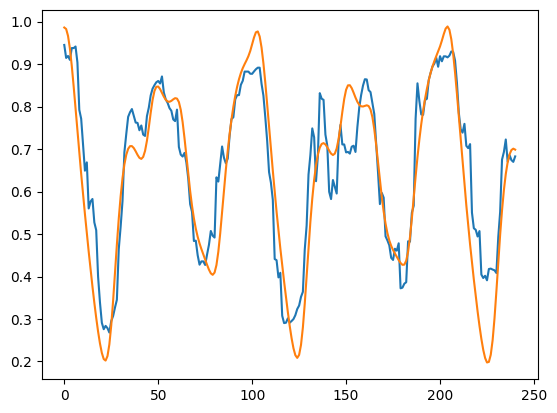

In [88]:
plt.plot(preds)
plt.plot(mackey_glass.y_val)

In [ ]:
plt.plot(preds)
plt.plot(mackey_glass.y_val)